<a href="https://colab.research.google.com/github/alvinnebula/DecisionTree_MapReduce/blob/main/DecisionTreeClassifierMapReduce_SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
!pip install --upgrade parallel-pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install  pyjanitor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, Normalizer, OneHotEncoder
import seaborn as sns; sns.set_style("dark")
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import janitor
#from parallel_pandas import ParallelPandas

In [5]:
from google.colab import drive
import os

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
drive.mount('/content/drive')
cur_path = "/content/drive/MyDrive/Big Data/Project"
os.chdir(cur_path)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_small = pd.read_csv("adult.csv").clean_names()
df_small.columns

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [8]:
cols = list(df_small.columns)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
df = pd.read_table("adult100k.txt", sep = ",", header = None)
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
for i in range(len(cols)):
    df = df.rename(columns= {i: cols[i]})
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_categorical_dtype

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
df["marital_relation"] = df["marital_status"] + "_" + df["relationship"]
df = df.drop(["sex","race","education_num", "native_country", "marital_status","relationship"], axis = 1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df.info()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   age               100000 non-null  int64 
 1   workclass         100000 non-null  object
 2   fnlwgt            100000 non-null  int64 
 3   education         100000 non-null  object
 4   occupation        100000 non-null  object
 5   capital_gain      100000 non-null  int64 
 6   capital_loss      100000 non-null  int64 
 7   hours_per_week    100000 non-null  int64 
 8   income            100000 non-null  object
 9   marital_relation  100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [14]:
df["income"] = df["income"].replace(["<=50K",">50K"], [0,1])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
train, test = train_test_split(df, random_state = 10, train_size = 0.8, stratify = df["income"])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
train_0 = train[train["income"] == 0]
train_0 = train_0.drop_duplicates()
train_1 = train[train["income"] == 1]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
train_new = pd.concat([train_0, train_1], axis = 0)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
x_train, y_train = train_new.drop("income", axis = 1), train_new["income"]
x_test, y_test = test.drop("income", axis = 1), test["income"]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Feature Engineering

In [19]:
num = []
cat = []
stri = []
columns = list(x_train.columns)
for col in columns:
    if is_numeric_dtype(x_train[col]):
        num.append(col)
    elif is_string_dtype(x_train[col]):
        stri.append(col)
    elif is_categorical_dtype(x_train[col]):
        cat.append(col)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
num, stri, cat

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week'],
 ['workclass', 'education', 'occupation', 'marital_relation'],
 [])

In [21]:
df["education"].unique()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [22]:
educ = ["education"]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
stri.remove("education")
num, stri, cat

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week'],
 ['workclass', 'occupation', 'marital_relation'],
 [])

In [24]:
min_max = MinMaxScaler()
ohe = OneHotEncoder()
ordi = OrdinalEncoder(categories = [["Preschool", "1st-4th","5th-6th", "7th-8th", "9th", "10th", 
                                            "11th", "12th", "HS-grad", "Some-college",
                                            "Assoc-voc","Assoc-acdm","Bachelors", "Masters","Prof-school","Doctorate"]])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
def column_transform(df, columns):
    new_df = df.copy()
    for col in columns:
        # num ~ [0,1]
        if col in num:
            ct = ColumnTransformer([("min_max", min_max, [col])])
            new_df[col + "_scaled"] = ct.fit_transform(df)
            continue
        # stri ~ {0,1}    
        elif col in stri:
            elements = sorted(df[col].unique())
            ct2 = ColumnTransformer([("ohe", ohe, [col])])
            if len(elements) > 2:
                x = ct2.fit_transform(df).toarray()
            elif len(elements) <= 2:
                x = np.array(ct2.fit_transform(df))
            for i in range(len(elements)):
                new_df[col + "_" + elements[i].lower()] = x[:,i]
        # depends on ord class
        elif col in educ:
            ct3 = ColumnTransformer([("ord", ordi, [col])])
            x = ct3.fit_transform(df)
            new_df[col + "_new"] = x
            continue
    new_df = new_df.drop(columns, axis = 1)
    return new_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
new_train_data = column_transform(x_train, list(x_train.columns))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
new_train_data["income"] = train_new["income"]

#new_train_data['education_new']
# 'age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week'

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
def column_fit_transform(train, other, columns):
    new_df = other.copy()
    for col in columns:
        # minmax
        if col in num:
            ct = ColumnTransformer([("min_max", min_max, [col])])
            ct.fit(train)
            new_df[col + "_scaled"] = ct.transform(other)
        # ohe
        elif col in stri:
            elements = sorted(other[col].unique())
            ct2 = ColumnTransformer([("ohe", ohe, [col])])
            if len(elements) > 2:
                ct2.fit(train)
                x = ct2.transform(other).toarray()
            elif len(elements) <= 2:
                ct2.fit(train)
                x = np.array(ct2.transform(other))
            for i in range(len(elements)):
                new_df[col + "_" + elements[i].lower()] = x[:,i]
        # ord
        elif col in educ:
            ct3 = ColumnTransformer([("ord", ordi, [col])])
            ct3.fit(train)
            x = ct3.transform(other)
            new_df[col + "_new"] = x
        
    new_df = new_df.drop(columns, axis = 1)
    return new_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
new_test_data = column_fit_transform(x_train, x_test, x_train.columns)
test_col, train_col = list(new_test_data.columns), list(new_train_data.columns)
missing = list(set(train_col).difference(set(test_col)))
for miss in missing:
    new_test_data[missing] = 0.0
new_test_data = new_test_data.drop("income", axis = 1)
new_test_data.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age_scaled,workclass_?,workclass_federal-gov,workclass_local-gov,workclass_never-worked,workclass_private,workclass_self-emp-inc,workclass_self-emp-not-inc,workclass_state-gov,workclass_without-pay,...,marital_relation_separated_other-relative,marital_relation_separated_own-child,marital_relation_separated_unmarried,marital_relation_separated_wife,marital_relation_widowed_husband,marital_relation_widowed_not-in-family,marital_relation_widowed_other-relative,marital_relation_widowed_own-child,marital_relation_widowed_unmarried,marital_relation_widowed_wife
8493,0.438356,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65084,0.767123,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7537,0.109589,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67022,0.082192,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9650,0.712329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Decision Tree Algorithm

In [30]:
## function for calculating entropy
def getEntropy(counts):
    percentages = counts/np.sum(counts)

    entr = 0
    for per in percentages:
        if per == 0:
            continue
        entr = entr - (per*np.log2(per))
    return entr

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# function for calculating entropy for each variable
def dataEntropy(data):
    
    high_income = len(data[data["income"] == 1])
    low_income = len(data[data["income"] == 0])
    
    result = getEntropy([low_income,high_income])
    return result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# function for obtaining aggregated entropy
def dataGivenEntropy(dataX, dataY):
    entrX = dataEntropy(dataX)
    entrY = dataEntropy(dataY)
    nX = len(dataX)
    nY = len(dataY)
    n = nX + nY
    if n == 0: 
        result = 0
    else:
        result = nX/n*entrX + nY/n*entrY
    return result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# function for calculating information gain to decide which column to split on
def infoGain(data, dataX, dataY):
    result = dataEntropy(data) - dataGivenEntropy(dataX, dataY)
    return result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# function for calculating gini
def getGini(counts):
    percentages = counts/np.sum(counts)
    gini = 1-np.sum(percentages**2)
    return gini

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
len(new_train_data["age_scaled"].unique())

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


73

In [36]:
def variance(data):
    income = data["income"]

    var = sum(income**2)/len(income) - (np.mean(income))**2

    return var

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# function for calculating the best split
def findBestSplit(data, label):
    minEntropy = 1
    colSelected = str()
    thresh_value = 0
    dataX_found,dataY_found = None, None
    for col in list(data.columns):
        if col != label:
        # make the split 

            if len(data[col].unique()) > 2:
                max = data[col].max()
                threshold = np.linspace(0,max,30)[1:-1]
                infoGainList = []

          # for 28 different thresholds, calculate the info-gain
                for i in range(len(threshold)):
                    dataX = data[data[col] > threshold[i]]
                    dataY = data[data[col] <= threshold[i]]
                    infoGainList.append(infoGain(data, dataX, dataY))

          # get the max info-gain
                idx = np.argmax(infoGainList)
                dataX = data[data[col] > threshold[idx]]
                dataY = data[data[col] <= threshold[idx]]
                thresh = threshold[idx]

            else:
                thresh = 0.5
                dataX = data[data[col] > thresh]
                dataY = data[data[col] <= thresh]
            
          
        entr = dataGivenEntropy(dataX, dataY)
        
        
        if entr < minEntropy:
            minEntropy = entr
            colSelected = col
            dataX_found = dataX
            dataY_found = dataY
            thresh_value = thresh
        

    return colSelected, minEntropy, dataX_found, dataY_found, thresh_value

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# function for calculating the best split
def split_via_mapreduce(data, col, label):
    minEntropy = 1
    colSelected = str()
    thresh_value = 0
    dataX_found,dataY_found = None, None
    if len(data[col].unique()) > 2:
        maxi = data[col].max()
        threshold = np.linspace(0,maxi,30)[1:-1]
        infoGainList = []

          # for 28 different thresholds, calculate the info-gain
        for i in range(len(threshold)):
            dataX = data[data[col] > threshold[i]]
            dataY = data[data[col] <= threshold[i]]
            infoGainList.append(infoGain(data, dataX, dataY))

          # get the max info-gain
        idx = np.argmax(infoGainList)
        dataX = data[data[col] > threshold[idx]]
        dataY = data[data[col] <= threshold[idx]]
        thresh = threshold[idx]

    else:
        thresh = 0.5
        dataX = data[data[col] > thresh]
        dataY = data[data[col] <= thresh]
            
          
    entr = dataGivenEntropy(dataX, dataY)
        
        
    minEntropy = entr
    colSelected = col
    dataX_found = dataX
    dataY_found = dataY
    thresh_value = thresh
        

    return colSelected, minEntropy, dataX_found, dataY_found, thresh_value

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
findBestSplit(new_train_data, 'income')[0], findBestSplit(new_train_data, 'income')[1]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('capital_loss_scaled', 0.9306597422914664)

In [40]:
# function for calculating the best split
def entropy_columns(data, label = "income"):
    #data = data_insert.toPandas()
    columns = []
    entropies = []
    combo = []
    combo2 = []
    dataX_found,dataY_found = None, None
    for col in list(data.columns):
        if col != label:
        # make the split 

            if len(data[col].unique()) > 2:
                maxi = data[col].max()
                threshold = np.linspace(0,maxi,30)[1:-1]
                infoGainList = []

              # for 28 different thresholds, calculate the info-gain
                for i in range(len(threshold)):
                    dataX = data[data[col] > threshold[i]]
                    dataY = data[data[col] <= threshold[i]]
                    infoGainList.append(infoGain(data, dataX, dataY))

              # get the max info-gain
                idx = np.argmax(infoGainList)
                dataX = data[data[col] > threshold[idx]]
                dataY = data[data[col] <= threshold[idx]]
                thresh = threshold[idx]

            else:
                thresh = 0.5
                dataX = data[data[col] > thresh]
                dataY = data[data[col] <= thresh]
            
          
            entr = dataGivenEntropy(dataX, dataY)
            columns.append(col)
            entropies.append(entr)
            t = col, entr
            combo.append(t)
    return combo

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
t = entropy_columns(new_train_data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
import multiprocessing as mp

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
def findBestSplitMapReduce(data, s):
    if len(data) >= s:
        n = len(data) // s
        n_1 = n + 1
        data = data.sample(frac = 1)
        p = mp.Pool(processes=n_1)
        conf = SparkConf().setAppName("DecisionTreeMapReduce")
        sc = SparkContext(conf = conf)
        df_parallel = np.array_split(data, n_1)
        res = p.map_async(entropy_columns, df_parallel).get()
        res_list = [item for sublist in res for item in sublist]
        res_rdd = sc.parallelize(res_list)
        new_res = res_rdd.reduceByKey(lambda a,b: a + b)
        res_use = new_res.collect()
        score = np.array([j/n_1 for i, j in res_use])
        arr_ind = list(np.nonzero(score > 0))
        col_name = np.array([i for i, j in res_use])
        col_name = col_name[arr_ind]
        score = score[arr_ind]
        column_to_use = col_name[np.argmin(score)]
        result = split_via_mapreduce(data, column_to_use, "income")
        sc.stop()
        p.close()
    else: 
        result = findBestSplit(data, "income")
    return result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
#findBestSplitMapReduce(new_train_data, 10000)[4]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
#findBestSplitMapReduce(new_train_data[new_train_data["capital_loss_scaled"] <= 0.034], 10000)[1]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
#findBestSplitMapReduce(new_train_data[new_train_data["capital_loss_scaled"] <= 0.034], 10000)[0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
#findBestSplitMapReduce(new_train_data[new_train_data["capital_loss_scaled"] <= 0.034], 10000)[4]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# class for recording branch information for each split
class Branch:
    no=0
    depth=1
    column=''
    entropy=0
    value = []
    samples = 0
    gini = 0
    thresh = 0
    branch_positive=None
    branch_negative=None
    positive=0
    negative=0
    num_cols = 0
    col_names = []

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
## function for building the decision tree for each split
number = 0
def decisionTreeInner(data, label, depth, max_depth, max_features, min_samples_split, min_samples_leaf, s):
    global number
    branch = Branch()
    branch.no = number
    number += 1
    branch.depth = depth
    branch.num_depth = 1
    
    branch.samples = data.shape[0]
    positive = data[data[label]==1].shape[0]
    negative = data[data[label]==0].shape[0]
    
    branch.value= [negative, positive]
    branch.gini = getGini(branch.value)
    
    bestSplit = findBestSplitMapReduce(data, s=s)
    #bestSplit = findBestSplit(data, "income")
    
    branch.column = bestSplit[0]
    branch.col_names.append(branch.column)
    cols = list(set(branch.col_names))
    branch.num_cols = len(cols)
    branch.entropy = bestSplit[1]
    
    newEntropy = bestSplit[1]
    dataNegative = bestSplit[2]
    dataPositive = bestSplit[3]
    branch.thresh = bestSplit[4]
    sum_val = branch.value[0] + branch.value[1]
    
    if sum_val != 0:
        unbalanced_0 = branch.value[0]/sum_val
        unbalanced_1 = branch.value[1]/sum_val
    
    if len(cols) < max_features:
        if depth == max_depth or branch.column == "" or branch.samples <= min_samples_split or (len(dataNegative) <= min_samples_leaf and len(dataPositive) <= min_samples_leaf) or (unbalanced_0 > 0.95 and branch.samples <= 1000) or (unbalanced_1 > 0.95 and branch.samples <= 1000):
          
            branch.positive = number
            number +=1
            branch.negative = number
            number +=1   
            branch.column = ""
    
            return branch
        
        # next step
        else:
            
            #dataNegative = bestSplit[2]
            branch.branch_negative = decisionTreeInner(dataNegative, label, depth+1, max_depth=max_depth, max_features = max_features, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, s = s)
            
            #dataPositive = bestSplit[3]
            branch.branch_positive = decisionTreeInner(dataPositive, label, depth+1, max_depth=max_depth, max_features = max_features, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, s = s)

            return branch
    else:
        
        if depth == max_depth or branch.column == "" or branch.samples <= min_samples_split or (len(dataNegative) <= min_samples_leaf and len(dataPositive) <= min_samples_leaf) or (unbalanced_0 > 0.95 and branch.samples <= 1000) or (unbalanced_1 > 0.95 and branch.samples <= 1000):
            
            branch.positive = number
            number +=1
            branch.negative = number
            number +=1   
            branch.column = ""
            
            return branch
        
        else:
            if "" in cols:
                cols.remove("")
            cols.append("income")
            
            #dataNegative = bestSplit[2]
            dataNegative = dataNegative[cols]
            
            branch.branch_negative = decisionTreeInner(dataNegative, label, depth+1, max_depth=max_depth, max_features = max_features, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, s = s)
            
            #dataPositive = bestSplit[3]
            dataPositive= dataPositive[cols]
            
            branch.branch_positive = decisionTreeInner(dataPositive, label, depth+1, max_depth=max_depth, max_features = max_features, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, s = s)
            cols.remove("income")
            return branch


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
## function for creating the decision tree classifier.
def decision_tree(data, label, max_depth, max_features, min_samples_split, min_samples_leaf, s):
    class Branch:
        no=0
        depth=1
        column=''
        entropy=0
        value = []
        samples = 0
        gini = 0
        thresh = 0
        branch_positive=None
        branch_negative=None
        positive=0 
        negative=0
        num_cols = 0
        col_names = []
      
    number = 0
    entropy = dataEntropy(data)
    columns = []
    tree = decisionTreeInner(data, label, 0, max_depth = max_depth, max_features = max_features, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, s = s)
    return tree

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
import warnings
warnings.filterwarnings('ignore')
import time
start=time.time()
my_dt = decision_tree(new_train_data, 'income', max_depth=3, max_features = 10, min_samples_split = 400, min_samples_leaf = 250, s = 10000)
print(round(time.time()-start, 2), 'seconds')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


79.92 seconds


In [52]:
my_dt.samples

79983

In [53]:
my_dt

In [54]:
def get_dot_data_innner(branch:Branch, classes, dot_data):
    if branch.value[0]<branch.value[1]:
        the_class=classes[0]
    else:
        the_class=classes[1]
    if branch.branch_positive:
        dot_data=dot_data+'{} [label=<{} le {:.2f}<br/>entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.column, branch.thresh, branch.entropy, branch.samples, branch.value, the_class)
    else:
        dot_data=dot_data+'{} [label=<entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.entropy, branch.samples, branch.value, the_class)
    if branch.branch_negative:
        dot_data=dot_data+'{} -> {} [labeldistance=2.5, labelangle=45, headlabel="no"]; \r\n'.format(branch.no, branch.branch_negative.no)
        dot_data=get_dot_data_innner(branch.branch_negative, classes, dot_data)
        
    if branch.branch_positive:
        dot_data=dot_data+'{} -> {} [labeldistance=1.5, labelangle=45, headlabel="yes"]; \r\n'.format(branch.no, branch.branch_positive.no)
        dot_data=get_dot_data_innner(branch.branch_positive, classes, dot_data)
  

    return dot_data
    
def get_dot_data(branch:Branch, classes=['above 50K','below 50K']):
    dot_data="""
digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
"""
    dot_data=get_dot_data_innner(branch, classes,  dot_data)
    dot_data=dot_data+'\r\n}'
    return dot_data

In [55]:
dot_data=get_dot_data(my_dt)

In [56]:
import graphviz 

In [57]:
graph = graphviz.Source(dot_data) 

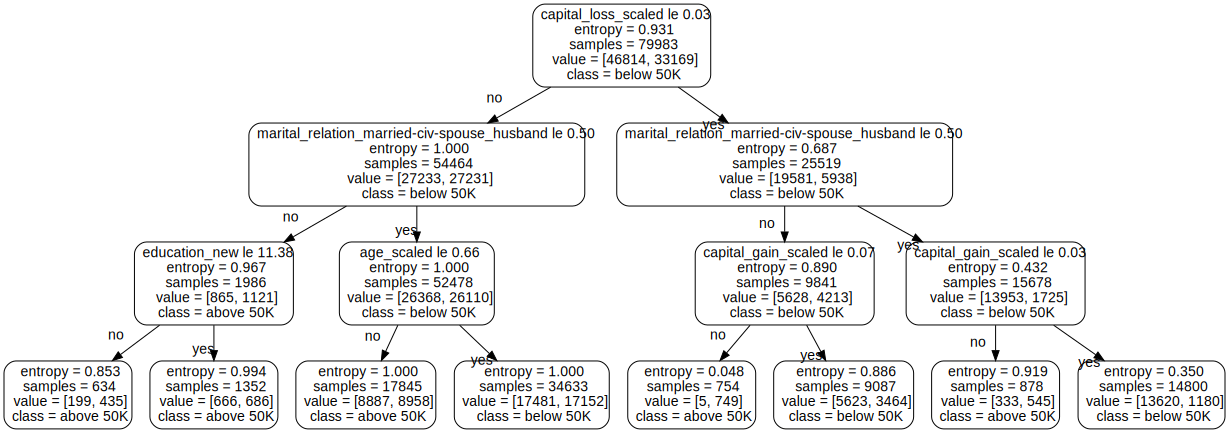

In [58]:
graph

In [59]:
#graph.render('./image/my_dt', format='png')

### Evaluating on Test data

In [60]:
new_train_data["income"].value_counts()

0    46814
1    33169
Name: income, dtype: int64

In [61]:
my_dt.samples

79983

In [62]:
start=time.time()
my_dt = decision_tree(new_train_data, 'income', max_depth=13, max_features = 15, min_samples_split = 500, min_samples_leaf = 250, s = 10000)
print(round(time.time()-start, 2), 'seconds')

292.37 seconds


In [63]:
def tree_predict(my_dt, obs, prop):
  out_dt = my_dt
  income = ""
  while out_dt.column != "":
    if obs[out_dt.column] <= out_dt.thresh:
      out_dt = out_dt.branch_positive
    else:
      out_dt = out_dt.branch_negative
  
  if out_dt.value[1]/(out_dt.value[1] + out_dt.value[0]) >= prop:
    income = 1
  else:
    income = 0
  
  return out_dt, income

In [64]:
prop = list(np.linspace(0,1, 100))[1:-1]

In [65]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [66]:
new_test_data_use = new_test_data.reset_index(drop = True)

In [67]:
def tree_pred_threshold(prop):
  incomes = []
  for i in range(len(new_test_data_use)):
    out_dt, income = tree_predict(my_dt, new_test_data_use.iloc[i,:], prop)
    incomes.append(income)

  precision = precision_score(y_test, incomes)
  recall = recall_score(y_test, incomes)
  accuracy = accuracy_score(y_test, incomes)
  
  return precision, recall, accuracy

In [68]:
precisions = []
recalls = []
accuracy = []
for i in range(len(prop)):
  res = tree_pred_threshold(prop[i])
  precisions.append(res[0])
  recalls.append(res[1])
  accuracy.append(res[2])

In [69]:
prop[np.argmax(accuracy)], accuracy[np.argmax(accuracy)]

(0.6060606060606061, 0.61465)

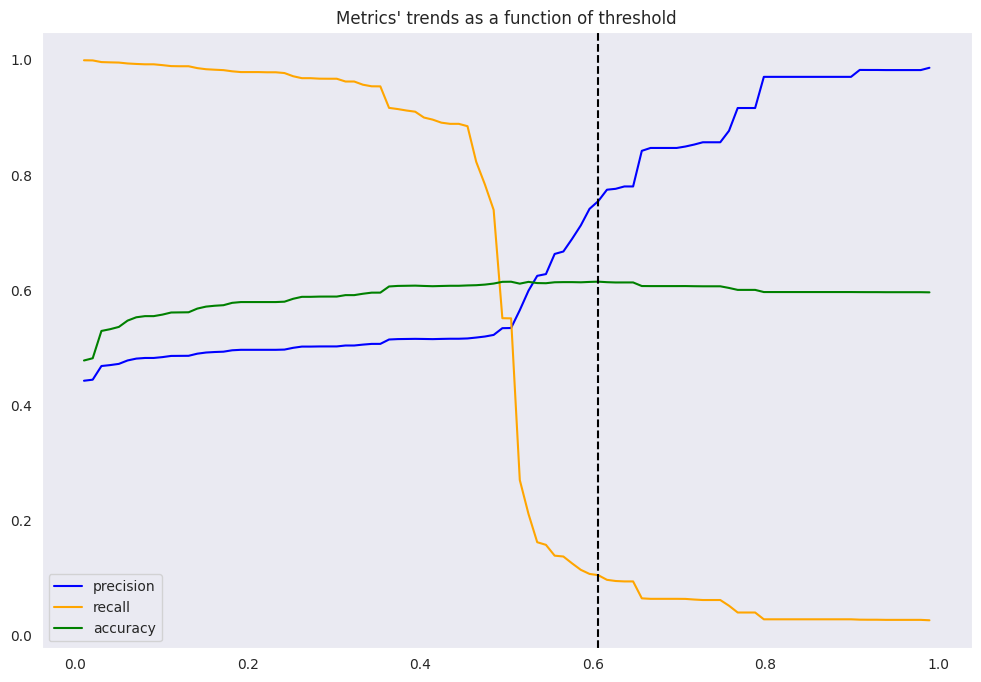

In [70]:
plt.figure(figsize = (12,8))
sns.lineplot(x = prop, y = precisions, color = "blue", label = "precision")
sns.lineplot(x = prop, y = recalls, color = "orange", label = "recall")
sns.lineplot(x = prop, y = accuracy, color = "green", label = "accuracy")
plt.axvline(x = prop[np.argmax(accuracy)], color = "black", linestyle = "dashed")
plt.title("Metrics' trends as a function of threshold")
plt.show();

In [71]:
incomes = []
out_vals = []
for i in range(len(new_test_data_use)):
  out_dt, income = tree_predict(my_dt, new_test_data_use.iloc[i,:], prop[np.argmax(accuracy)])
  incomes.append(income)
  out_vals.append(out_dt.value)

In [72]:
from collections import Counter
Counter(incomes)

Counter({0: 18851, 1: 1149})

In [73]:
out_vals[:10]

[[1677, 40],
 [286, 277],
 [618, 17],
 [5670, 5872],
 [467, 854],
 [5670, 5872],
 [5670, 5872],
 [183, 163],
 [5670, 5872],
 [937, 880]]

In [74]:
out_dt, income = tree_predict(my_dt, new_test_data.iloc[1000,:], prop[np.argmax(accuracy)])

In [75]:
out_dt.value

[5670, 5872]

In [76]:
income

0

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [78]:
print(classification_report(y_test, incomes))

              precision    recall  f1-score   support

           0       0.61      0.98      0.75     11708
           1       0.75      0.10      0.18      8292

    accuracy                           0.61     20000
   macro avg       0.68      0.54      0.47     20000
weighted avg       0.67      0.61      0.51     20000



In [79]:
conf = confusion_matrix(y_test,incomes)

<Axes: >

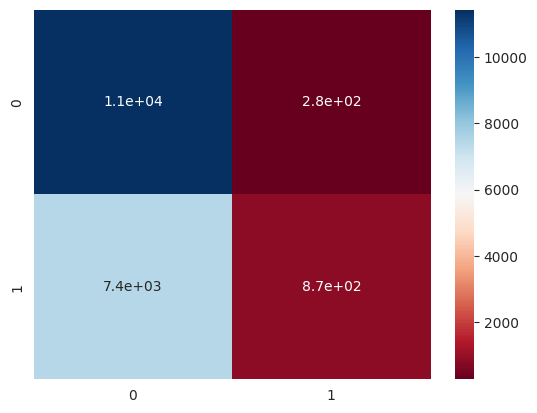

In [80]:
sns.heatmap(conf, annot = True, cmap = "RdBu")

### Column Frequency

In [81]:
from collections import Counter
col_dict = dict(Counter(my_dt.col_names))

In [82]:
col_df = pd.DataFrame({"variable": list(col_dict.keys()), "frequency": list(col_dict.values())})

In [83]:
col_df = col_df[col_df["variable"] != ""]

In [84]:
col_df

,variable,frequency
0,capital_loss_scaled,2
1,marital_relation_married-civ-spouse_husband,4
2,education_new,37
3,capital_gain_scaled,45
4,hours_per_week_scaled,31
5,age_scaled,47
6,fnlwgt_scaled,39
7,workclass_without-pay,13
8,marital_relation_married-civ-spouse_wife,18
9,workclass_self-emp-inc,21
